# PRYECTO 1

## Librerias

In [14]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
from datetime import datetime
import pytz
import glob

import re

import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import glob

In [15]:
df_lat_long = pd.concat([pd.read_csv(f) for f in glob.glob('../data-scraped/lat-long/*.csv')], ignore_index=True).drop_duplicates().dropna()
df_lat_long.head()

,url,latitude,longitude
0,https://portalinmobiliario.com/MLC-2955917298-...,-33.449150,-70.634858
1,https://portalinmobiliario.com/MLC-2956135138-...,-33.375820,-70.545286
2,https://portalinmobiliario.com/MLC-2955917292-...,-33.451932,-70.660507
3,https://portalinmobiliario.com/MLC-2954917736-...,-33.447844,-70.647128
4,https://portalinmobiliario.com/MLC-2956135118-...,-33.387264,-70.543598


In [16]:
df_apartments = pd.concat([pd.read_csv(f) for f in glob.glob('../data-scraped/rental-apartment/*.csv')], ignore_index=True)
df_apartments['apartment_id'] = df_apartments['link'].str.split('-').str[1].astype('int64')
df_apartments.drop_duplicates(subset='apartment_id', inplace=True)

df_apartments['price_unit'] = df_apartments.price.str.split(' ').str[0]
df_apartments['price_value'] = df_apartments.price.str.split(' ').str[1].str.replace('.', '').astype('int64')

df_apartments['city'] = df_apartments.location.str.split(',').str[-1].str.strip()
df_apartments['district'] = df_apartments.location.str.split(',').str[-2].str.strip()
df_apartments['street'] = df_apartments.location.str.split(',').str[-3].str.strip()

df_apartments['url'] = df_apartments.link.str.split('#').str[0]

df_apartments = df_apartments.merge(df_lat_long, on='url', how='left')

df_apartments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1412 entries, 0 to 1411
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           1412 non-null   object 
 1   price           1412 non-null   object 
 2   location        1412 non-null   object 
 3   attributes      1412 non-null   object 
 4   link            1412 non-null   object 
 5   date_processed  1412 non-null   object 
 6   page_number     1412 non-null   int64  
 7   apartment_id    1412 non-null   int64  
 8   price_unit      1412 non-null   object 
 9   price_value     1412 non-null   int64  
 10  city            1412 non-null   object 
 11  district        1412 non-null   object 
 12  street          1412 non-null   object 
 13  url             1412 non-null   object 
 14  latitude        1412 non-null   float64
 15  longitude       1412 non-null   float64
dtypes: float64(2), int64(3), object(11)
memory usage: 176.6+ KB


In [17]:
no_districts_mapping = {
    "Barrio El Golf": "Las Condes",
    "Plaza Vespucio": "La Florida",
    "La Florida Alto": "La Florida",
    "Parque Bicentenario": "Vitacura",
    "El Llano": "San Miguel",
    "Metro Escuela Militar": "Las Condes",
    "Parque Almagro": "Santiago",
    "Bogotá - Sierra Bella": "Santiago",
    "Parque O'Higgins": "Santiago",
    "Puente Nuevo": "Puente Alto",
    "Los Trapenses": "Lo Barnechea",
    "Pío XI": "Lo Barnechea",
    "Metro Las Rejas": "Estación Central",
    "Lo Ovalle": "San Miguel",
    "Parque Juan XXIII": "Ñuñoa",
    "Lo Curro": "Vitacura",
    "La Dehesa": "Lo Barnechea",
    "Centro Financiero": "Las Condes",
    "Metro Irarrázaval": "Ñuñoa",
    "Las Lilas": "Providencia",
    "Lo Vial": "San Miguel"
}

df_apartments['district'] = df_apartments['district'].map(no_districts_mapping).fillna(df_apartments['district'])


In [18]:
socioeconomic_mapping = {
    "Vitacura": "Alto",
    "Lo Barnechea": "Alto",
    "Las Condes": "Alto",
    "Providencia": "Alto",
    "La Reina": "Alto",
    
    "Ñuñoa": "Medio-Alto",
    "Macul": "Medio-Alto",
    "San Miguel": "Medio-Alto",
    "La Florida": "Medio-Alto",
    "Independencia": "Medio-Alto",
    "Recoleta": "Medio-Alto",
    "Huechuraba": "Medio-Alto",
    'Peñalolén': "Medio-Alto",
    
    "Santiago": "Medio-Bajo",
    "Estación Central": "Medio-Bajo",
    "Quinta Normal": "Medio-Bajo",
    "Cerrillos": "Medio-Bajo",
    "Maipú": "Medio-Bajo",
    "Puente Alto": "Medio-Bajo",
    "La Cisterna": "Medio-Bajo",
    "Pedro Aguirre Cerda": "Medio-Bajo",
    "Renca": "Medio-Bajo",
    "Quilicura": "Medio-Bajo",
    "La Granja": "Medio-Bajo",
    "San Bernardo": "Medio-Bajo",
    "Lo Prado": "Medio-Bajo",
    "Conchalí": "Medio-Bajo",
    "Padre Hurtado": "Medio-Bajo",
    "Pudahuel": "Medio-Bajo",
    "San Joaquín": "Medio-Bajo",
}

df_apartments['socioeconomic_level'] = df_apartments['district'].map(socioeconomic_mapping)


In [19]:
df_apartments['number_of_bedrooms'] = df_apartments.attributes.str.split(',').str[-3].str.split(' ').str[0]
df_apartments['number_of_bathrooms'] = df_apartments.attributes.str.split(',').str[-2]
df_apartments['total_square_meters'] = df_apartments.attributes.str.split(',').str[-1]

# Compilamos patrones separados
bedrooms_pattern = re.compile(r'(\d+(?:\s*a\s*\d+)?)\s*dormitorios?')
bathrooms_pattern = re.compile(r'(\d+(?:\s*a\s*\d+)?)\s*baños?')
sqm_pattern = re.compile(r'(\d+(?:\.\d+)?(?:\s*-\s*\d+(?:\.\d+)?)?)\s*m²\s*(?:útiles|totales)')

def extract_attributes(attr):
    if not attr:
        return None, None, None
    
    attr = attr.replace('m��', 'm²')
    
    bedrooms_match = bedrooms_pattern.search(attr)
    bathrooms_match = bathrooms_pattern.search(attr)
    sqm_match = sqm_pattern.search(attr)
    
    def parse_number(s):
        if not s:
            return None
        s = s.replace(" ", "")
        if "-" in s:
            parts = s.split("-")
            return float(parts[1])
        if "a" in s:
            parts = s.split("a")
            return float(parts[1])
        return float(s)

    
    bedrooms = parse_number(bedrooms_match.group(1)) if bedrooms_match else None
    bathrooms = parse_number(bathrooms_match.group(1)) if bathrooms_match else None
    sqm = parse_number(sqm_match.group(1)) if sqm_match else None
    
    return bedrooms, bathrooms, sqm

# Aplicar la regex a la columna attributes
df_apartments[['number_of_bedrooms', 'number_of_bathrooms', 'total_square_meters']] = df_apartments['attributes'].apply(extract_attributes).apply(pd.Series)

# MAPA

## mapa geo 1

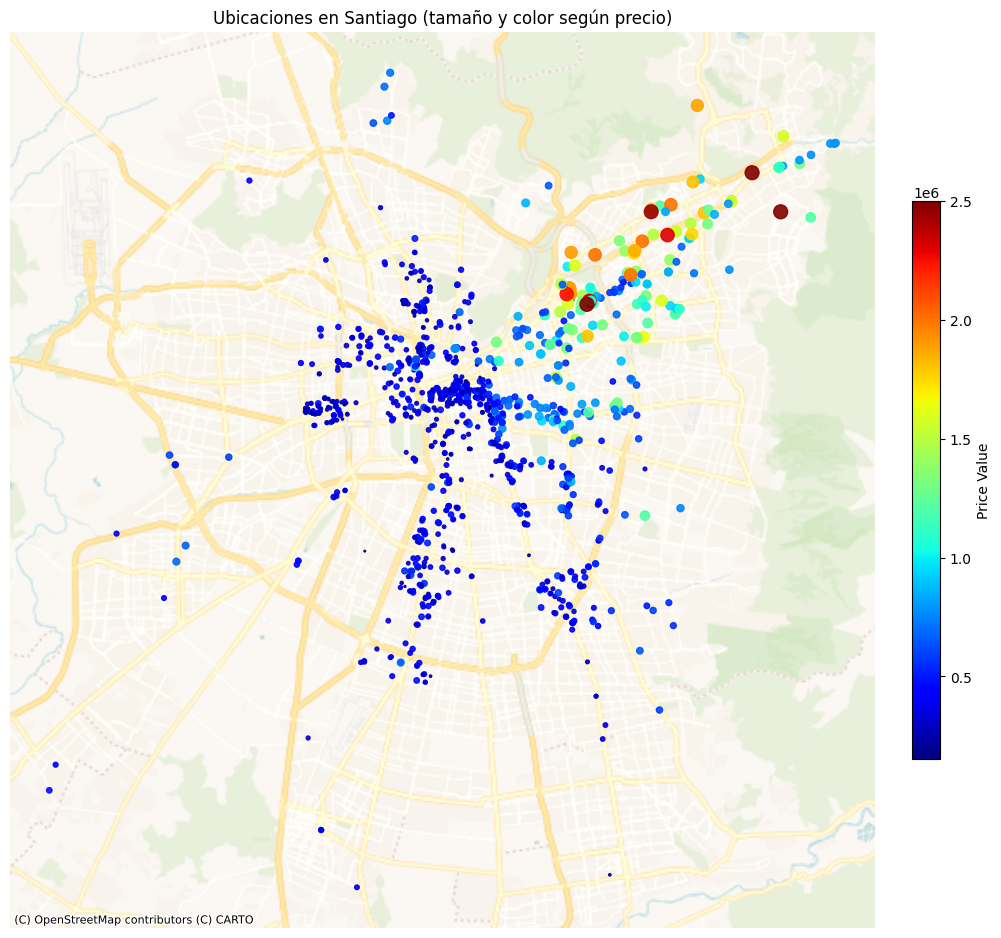

In [ ]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

df = df_apartments.query('price_unit == "$" and price_value <= 2500000 ').copy() #and socioeconomic_level == "Alto"

# 1. Crear GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)

# 2. Convertir a Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)

# 3. Escalar price_value para markersize
min_size = 1
max_size = 100

price_min = gdf['price_value'].min()
price_max = gdf['price_value'].max()

gdf['total_square_meters'] = ((gdf['price_value'] - price_min) / (price_max - price_min)) * (max_size - min_size) + min_size

# 4. Crear un colormap y normalizador para price_value
norm = mcolors.Normalize(vmin=price_min, vmax=price_max)
cmap = cm.jet

# Asignar colores a cada punto según price_value
gdf['color'] = gdf['price_value'].apply(lambda x: cmap(norm(x)))

# 5. Graficar con tamaño y color
fig, ax = plt.subplots(figsize=(12, 12))
scatter = gdf.plot(
    ax=ax,
    alpha=0.9,
    edgecolor=None,
    color=gdf['color'],
    markersize=gdf['total_square_meters'],
)

# 6. Agregar mapa base de OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels)
# OpenStreetMap.Mapnik
# CartoDB.Positron
# CartoDB.DarkMatter

# 7. Quitar ejes
ax.set_axis_off()

# 8. Añadir barra de color
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Dummy array for the ScalarMappable
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Price Value')

plt.title("Ubicaciones en Santiago (tamaño y color según precio)")
plt.show()


In [61]:

print(dir(ctx.providers.OpenStreetMap))

['BZH', 'CAT', 'CH', 'DE', 'France', 'HOT', 'Mapnik']


In [57]:
print(dir(ctx.providers.CartoDB))
# print(dir(ctx.providers.Stadia))
# print(dir(ctx.providers.Thunderforest))


['DarkMatter', 'DarkMatterNoLabels', 'DarkMatterOnlyLabels', 'Positron', 'PositronNoLabels', 'PositronOnlyLabels', 'Voyager', 'VoyagerLabelsUnder', 'VoyagerNoLabels', 'VoyagerOnlyLabels']


## mapa geo 2

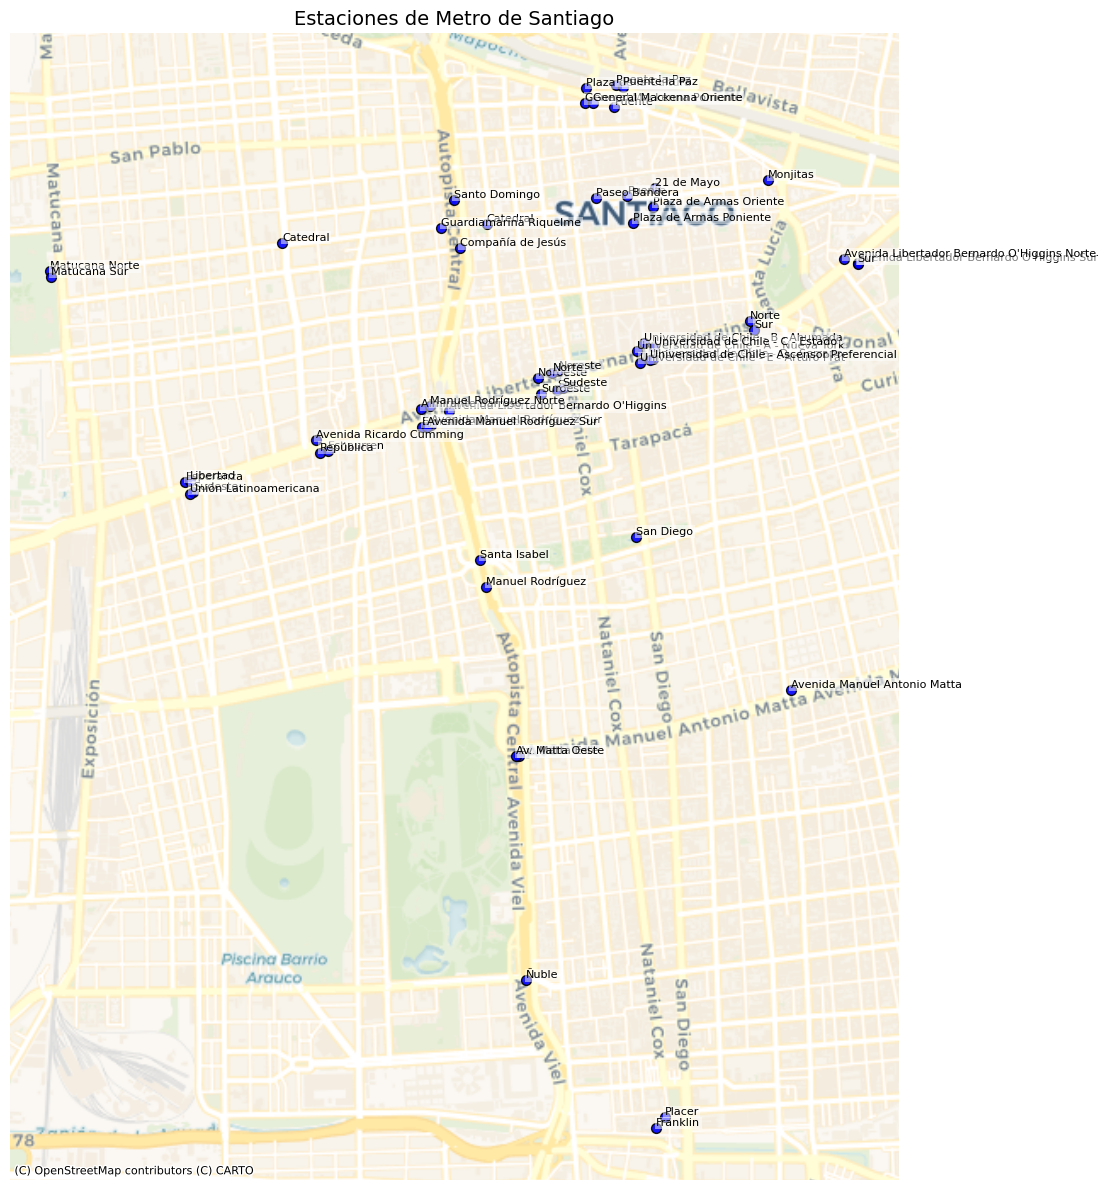

In [4]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Si tu DataFrame se llama df_stations
df = df_stations.copy()

# 1. Convertir a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)

# 2. Transformar a Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)

# 3. Graficar
fig, ax = plt.subplots(figsize=(12, 12))

# Puntos de estaciones
gdf.plot(
    ax=ax,
    color="blue",
    edgecolor="k",
    alpha=0.9,
    markersize=50
)

# Etiquetas de nombre
for x, y, label in zip(gdf.geometry.x, gdf.geometry.y, gdf["name"]):
    ax.text(
        x,
        y,
        label,
        fontsize=8,
        ha="left",
        va="bottom",
        color="black",
        bbox=dict(facecolor="white", alpha=0.5, edgecolor="none", pad=1)
    )

# Mapa base
ctx.add_basemap(
    ax,
    source=ctx.providers.CartoDB.Voyager
)

ax.set_axis_off()
plt.title("Estaciones de Metro de Santiago", fontsize=14)
plt.tight_layout()
plt.show()


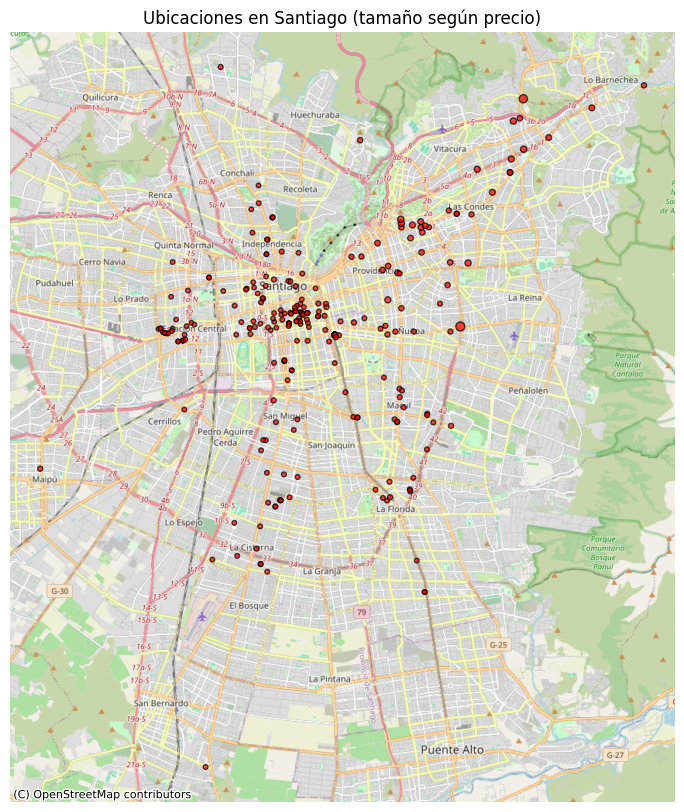

In [19]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

df = df_apartments.query('price_unit == "$"').copy()

# 1. Crear GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
    crs="EPSG:4326"
)

# 2. Convertir a Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)

# 3. Escalar price_value para markersize
min_size = 10
max_size = 400

price_min = gdf['price_value'].min()
price_max = gdf['price_value'].max()

gdf['size'] = ((gdf['price_value'] - price_min) / (price_max - price_min)) * (max_size - min_size) + min_size

# 4. Graficar con tamaño por price_value
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(
    ax=ax,
    alpha=0.7,
    edgecolor="k",
    color="red",
    markersize=gdf['size']
)

# 5. Agregar mapa base de OpenStreetMap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# 6. Quitar ejes
ax.set_axis_off()

plt.title("Ubicaciones en Santiago (tamaño según precio)")
plt.show()
